In [1]:
!pip install scikit-survival

In [2]:
!pip install catBoost

In [3]:
from sksurv.ensemble import RandomSurvivalForest
# from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis

import pandas as pd
import numpy as np
from sklearn import preprocessing
# from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, CatBoostRegressor, Pool

import warnings
warnings.simplefilter('ignore')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
clients = pd.read_csv('/content/drive/MyDrive/datasets/ottok/clients.csv')
train = pd.read_csv('/content/drive/MyDrive/datasets/ottok/train.csv')
transactions = pd.read_csv('/content/drive/MyDrive/datasets/ottok/transactions.csv', parse_dates=['transaction_dttm'])
report_dates = pd.read_csv('/content/drive/MyDrive/datasets/ottok/report_dates.csv', parse_dates=['report_dt'])

* user_id – ID клиента банка
* report — номер одного из 12 отчетов, в который попал этот клиент
* employee_count_nm – информация о работодателе клиента: число сотрудников в компании (осторожно, есть пропуски)
* bankemplstatus – информация о том, является ли клиент сотрудников банка
* customer_age – обфусцированный возраст клиента (до одной из 4 групп 0..3)

In [6]:
clients.tail(5)

,user_id,report,employee_count_nm,bankemplstatus,customer_age
95995,562043,12,NaN,0,2
95996,562205,12,NaN,0,1
95997,562312,12,NaN,0,0
95998,562721,12,NaN,0,2
95999,562740,12,NaN,0,0


In [7]:
clients.isna().sum()

user_id                  0
report                   0
employee_count_nm    36466
bankemplstatus           0
customer_age             0
dtype: int64

In [8]:
clients.employee_count_nm.value_counts()

employee_count_nm
БОЛЕЕ 1001        17833
ОТ 101 ДО 500     14362
ОТ 51 ДО 100       7314
ОТ 501 ДО 1000     6481
ОТ 11 ДО 50        4413
ДО 10              3797
БОЛЕЕ 500          1996
ОТ 11 ДО 30        1871
ОТ 31 ДО 50        1467
Name: count, dtype: int64

In [9]:
clients.employee_count_nm.isna().sum()

36466

In [10]:
clients['employee_count_nm'] = clients['employee_count_nm'].fillna('UNKNOWN')

In [11]:
clients.where(clients.bankemplstatus == 1).groupby('employee_count_nm').bankemplstatus.count()

employee_count_nm
UNKNOWN            56
БОЛЕЕ 1001        197
БОЛЕЕ 500           3
ДО 10               5
ОТ 101 ДО 500      13
ОТ 11 ДО 30         5
ОТ 11 ДО 50         2
ОТ 31 ДО 50         4
ОТ 501 ДО 1000     23
ОТ 51 ДО 100        5
Name: bankemplstatus, dtype: int64

In [12]:
# замена, так как значение повторяет другое значение
clients.replace({'employee_count_nm':{'БОЛЕЕ 500':'ОТ 501 ДО 1000'}}, inplace=True)

#также можно поставить количество от 501 для сотрудников банков
clients.loc[(clients['bankemplstatus'] == 1) & (clients['employee_count_nm'] == 'UNKNOWN'), 'employee_count_nm'] = 'ОТ 501 ДО 1000'

Варианты заполнения категориальных признаков для Forest

In [13]:
# заполнение пропусков SimpleImputer
# from sklearn.impute import SimpleImputer
# imputer = SimpleImputer(strategy='most_frequent')
# imputer = imputer.fit(clients[['employee_count_nm']])
# clients['employee_count_nm'] = imputer.transform(clients[['employee_count_nm']])
# encoder = preprocessing.LabelEncoder()
# encoder = encoder.fit(clients['employee_count_nm'])
# clients['employee_count_nm'] = encoder.transform(clients['employee_count_nm'])

In [14]:
# кодирование количества сотрудников по признаку есть инфо или нет
# clients['employee_count_nm'] = clients['employee_count_nm'].fillna('0')
# clients.replace({'employee_count_nm':{'ОТ 101 ДО 500':1,'БОЛЕЕ 1001':1,'ОТ 501 ДО 1000':1,'ДО 10':1,
                                      # 'ОТ 11 ДО 50':1,'ОТ 51 ДО 100':1,'БОЛЕЕ 500':1,'ОТ 11 ДО 30':1,
                                      # 'ОТ 31 ДО 50':1}}, inplace=True)

In [15]:
# clients = pd.get_dummies(clients, columns=['employee_count_nm'])

In [16]:
# нормализация столбца количество сотрудников (прирост не дает)
# clients['employee_count_nm'] = (clients['employee_count_nm'] - np.mean(clients['employee_count_nm'])) / np.std(clients['employee_count_nm'])

* user_id – ID клиента банка
* target – метка оттока клиента (целевой класс события оттока это 1)
* time – через сколько дней случится последняя транзакция клиента (можно использовать как survival time в Time-to-Event анализе)

In [17]:
train.sample(5)

,user_id,target,time
60068,517526,0,74
16108,137454,0,87
28076,244151,0,82
14888,127239,0,91
57843,497110,0,91


  * report – порядковый номер отчета
  * report_dt — дата отчета

In [18]:
report_dates.sample(5)

,report,report_dt
2,3,2022-09-30 03:00:00
10,11,2023-05-31 03:00:00
3,4,2022-10-31 03:00:00
1,2,2022-08-31 03:00:00
9,10,2023-04-30 03:00:00


* user_id – ID клиента банка
* mcc_code — mcc код транзакции
* currency_rk – валюта транзакции
* transaction_dttm – дата и время совершения операции
* transaction_amt –

In [19]:
transactions.sample(5)

,user_id,mcc_code,currency_rk,transaction_amt,transaction_dttm
9372711,373932,3,1,-92093.046875,2022-08-29 20:38:49
5566524,218099,1,1,-79.447830,2023-03-10 19:38:00
10828339,438550,4,1,-46.961651,2021-12-11 10:42:43
1473188,58779,3,1,-1641.764404,2022-10-05 17:53:25
3333008,134580,1,1,-212.940018,2022-02-08 15:05:22


In [20]:
transactions.currency_rk.value_counts()

currency_rk
1    12701022
0      370455
3        1795
2        1751
Name: count, dtype: int64

In [21]:
transactions.mcc_code.value_counts()

mcc_code
1      4152654
2      1065363
4       947720
3       719400
0       582177
        ...   
449          1
314          1
243          1
323          1
273          1
Name: count, Length: 332, dtype: int64

In [22]:
transactions.shape

(13075023, 5)

In [23]:
df = (clients
      .merge(train, how='left')
      .merge(report_dates, how='left')
      .merge(transactions, how='left'))

In [24]:
df.shape

(13075023, 12)

In [25]:
df['weekday'] = df['transaction_dttm'].apply(lambda x: x.weekday())

In [26]:
df['day'] = df['transaction_dttm'].apply(lambda x: x.day)

In [27]:
# самый частый тип транзакций & самая частая валюта транзакций

features = (df
            .groupby(['user_id'])
            .agg(
              freq_mcc=('mcc_code', lambda x: x.value_counts().index[0]),
              freq_currency=('currency_rk', lambda x: x.value_counts().index[0]),
              freq_weekday=('weekday', lambda x: x.value_counts().index[0]),
              freq_day=('day', lambda x: x.value_counts().index[0]))
              .reset_index()
            )
df =  df.drop(columns = ['weekday', 'day'])

In [28]:
features

,user_id,freq_mcc,freq_currency,freq_weekday,freq_day
0,3,0,1,4,28
1,9,1,1,5,1
2,13,3,1,4,15
3,37,2,1,2,3
4,41,3,1,0,16
...,...,...,...,...,...
95995,562043,1,1,3,9
95996,562205,11,1,4,28
95997,562312,1,1,5,22
95998,562721,3,1,4,27


In [29]:
# тип операции по последней транзакции
last_mcc = transactions.groupby(['user_id']).agg(last_mcc=('mcc_code', 'last')).reset_index()

In [30]:
# тип операции по последней транзакции
last_operation_summ = transactions.groupby(['user_id']).agg(last_operation_summ=('transaction_amt', 'last')).reset_index()
last_operation_summ['last_operation_type'] = np.where(last_operation_summ['last_operation_summ'] < 0, 1, 0)
# del features ['last_operation_summ']

In [31]:
rfm = df.reset_index().groupby('user_id').agg({'transaction_dttm': lambda date: (date.max() - date.min()).days,
                                                 'mcc_code': lambda num: num.count(),
                                                 'transaction_amt': lambda operation: abs(operation).sum()})
rfm.rename(columns={'transaction_dttm': 'days', #количество дней между 1 и последней транзакцией
                    'mcc_code': 'count_transactions', #количество транзакций по клиенту за период месяц
                    'transaction_amt': 'total_amount'}, inplace=True) #сумма транзакций

In [32]:
quantiles = rfm.quantile(q=[0.20, 0.40, 0.60, 0.80])
quantiles = quantiles.to_dict()
segmented_rfm = rfm.copy()

def RScore(x,p,d):
     if x <= d[p][0.20]:
         return 1
     elif x <= d[p][0.40]:
         return 2
     elif x <= d[p][0.60]:
         return 3
     elif x<=d[p][0.80]:
         return 4
     else:
         return 5

segmented_rfm['days'] = segmented_rfm['days'].apply(RScore, args=('days',quantiles))
segmented_rfm['count_transactions'] = segmented_rfm['count_transactions'].apply(RScore, args=('count_transactions',quantiles))
segmented_rfm['total_amount'] = segmented_rfm['total_amount'].apply(RScore, args=('total_amount',quantiles))
segmented_rfm['RFMScore'] = (segmented_rfm.days.map(str) + segmented_rfm.count_transactions.map(str) + segmented_rfm.total_amount.map(str)).astype('int16')
segmented_rfm = segmented_rfm.reset_index()
rfm = rfm.reset_index()

In [33]:
segmented_rfm =  segmented_rfm.drop(columns = ['days', 'count_transactions', 'total_amount'])
segmented_rfm

,user_id,RFMScore
0,3,114
1,9,534
2,13,214
3,37,454
4,41,112
...,...,...
95995,562043,121
95996,562205,441
95997,562312,121
95998,562721,333


In [34]:
"""сумма поступлений и расходов за весь период """
amount_in = df.where(df['transaction_amt'] > 0).groupby(['user_id'])['transaction_amt'].sum().reset_index(name='total_amount_in')
amount_out= df.where((df['transaction_amt'] < 0)).groupby(['user_id'])['transaction_amt'].sum().reset_index(name='total_amount_out')
amount_out['total_amount_out'] = abs(amount_out['total_amount_out'])

In [35]:
# """ признак больше трат, чем приходов """
df.loc[df['transaction_amt'] > 0, 'count_transactions_in'] = 1
df.loc[df['transaction_amt'] < 0, 'count_transactions_out'] = 1
df['count_transactions_in'] = df.groupby(['user_id'])['count_transactions_in'].transform('count')
df['count_transactions_out'] = df.groupby(['user_id'])['count_transactions_out'].transform('count')
df['more_operations_out'] = np.where(df['count_transactions_out'] - df['count_transactions_in'] > 0, 1, 0)
df =  df.drop(columns = ['count_transactions_in', 'count_transactions_out'])

In [36]:
df.head(3)

,user_id,report,employee_count_nm,bankemplstatus,customer_age,target,time,report_dt,mcc_code,currency_rk,transaction_amt,transaction_dttm,more_operations_out
0,3,2,ОТ 101 ДО 500,0,3,0.0,77.0,2022-08-31 03:00:00,3,1,-183.883957,2022-01-28 12:05:33,0
1,3,2,ОТ 101 ДО 500,0,3,0.0,77.0,2022-08-31 03:00:00,3,1,-3206.437012,2022-01-28 12:52:30,0
2,3,2,ОТ 101 ДО 500,0,3,0.0,77.0,2022-08-31 03:00:00,16,1,-153866.890625,2022-02-16 14:45:56,0


In [37]:
"""признак по времени суток, важность стремится к нулю"""

df.loc[df['transaction_dttm'].apply(lambda x: 12 >= x.hour >= 0), 'PM'] = 1
df.loc[df['transaction_dttm'].apply(lambda x: 12 < x.hour < 24), 'AM'] = 1
df['AM'] = df.groupby(['user_id'])['AM'].transform('count')
df['PM'] = df.groupby(['user_id'])['PM'].transform('count')
df['operation_time_00_12'] = np.where(df['PM'] - df['AM'] > 0, 1, 0)
df =  df.drop(columns = ['AM', 'PM'])

In [38]:
"""разница между датой последнего отчета и датой последней транзакции """
df['diff_report_transaction'] = df['report_dt'] - df['transaction_dttm']
diff = (df.groupby(['user_id'])['diff_report_transaction']
        .min()
        .apply(lambda x: x.days)
        .astype(np.int16)
        .reset_index(name='diff_report_transaction'))
df =  df.drop(columns = ['diff_report_transaction'])

In [39]:
diff

,user_id,diff_report_transaction
0,3,108
1,9,102
2,13,114
3,37,104
4,41,103
...,...,...
95995,562043,142
95996,562205,102
95997,562312,122
95998,562721,105


In [40]:
df =  df.drop(columns = ['transaction_dttm', 'transaction_amt', 'report_dt', 'mcc_code', 'currency_rk'])

In [41]:
df = df.drop_duplicates()

In [42]:
df = (df
      .merge(features)
      .merge(last_operation_summ)
      .merge(rfm)
      .merge(diff)
      .merge(last_mcc)
      .merge(segmented_rfm)
      .merge(amount_in, how='left')
      .merge(amount_out, how='left')
      )

In [43]:
df.replace({'days': {0:1}}, inplace=True)
df['day_mean_operations_count'] = df['count_transactions'] / df['days']
df =  df.drop(columns = ['count_transactions'])
# без этого признака чуть лучше показатель
del df['day_mean_operations_count']
df =  df.drop(columns = ['total_amount', 'days'])

In [44]:
df.shape

(96000, 20)

In [45]:
df.head(5)

,user_id,report,employee_count_nm,bankemplstatus,customer_age,target,time,more_operations_out,operation_time_00_12,freq_mcc,freq_currency,freq_weekday,freq_day,last_operation_summ,last_operation_type,diff_report_transaction,last_mcc,RFMScore,total_amount_in,total_amount_out
0,3,2,ОТ 101 ДО 500,0,3,0.0,77.0,0,0,0,1,4,28,104011.960938,0,108,0,114,186108.229797,172401.813156
1,9,1,БОЛЕЕ 1001,0,3,NaN,NaN,1,1,1,1,5,1,-4246.083008,1,102,39,534,NaN,323434.666813
2,13,6,ОТ 501 ДО 1000,0,2,0.0,86.0,1,0,3,1,4,15,-16394.193359,1,114,3,214,128766.684326,253484.063477
3,37,5,БОЛЕЕ 1001,0,2,0.0,89.0,1,0,2,1,2,3,-2030.448853,1,104,3,454,10738.788574,342598.388037
4,41,1,ОТ 101 ДО 500,0,2,0.0,57.0,1,0,3,1,0,16,-6226.305176,1,103,86,112,NaN,108586.614166


In [46]:
df['target'] = df['target'].fillna(-1).astype(np.int8)#('empty')

In [47]:
df_pred = df[df['target'] == -1]
submit = df_pred[['user_id']]

In [48]:
submit.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32000 entries, 1 to 95996
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   user_id  32000 non-null  int64
dtypes: int64(1)
memory usage: 500.0 KB


In [49]:
df = df[df['target'] != -1]
del df['user_id']

In [50]:
# кодирование количества сотрудников с помощью LabelEncoder для анализа
df_copy = df.copy()
df_copy['employee_count_nm'] = df_copy['employee_count_nm'].fillna('0')
encoder = preprocessing.LabelEncoder()
encoder = encoder.fit(df_copy['employee_count_nm'])
df_copy['employee_count_nm'] = encoder.transform(df_copy['employee_count_nm'])

Посмотрим связь целевой переменной с признаками (time)

In [51]:
# for feature in df_copy.columns:
#   plt.figure(figsize = (6,3))
#   sns.scatterplot(data = df_copy, y= 'time', x= feature, color='blue')
#   plt.grid()

In [52]:
df.loc[(df['last_operation_summ'] < 0) & (df['target'] == 1)]

,report,employee_count_nm,bankemplstatus,customer_age,target,time,more_operations_out,operation_time_00_12,freq_mcc,freq_currency,freq_weekday,freq_day,last_operation_summ,last_operation_type,diff_report_transaction,last_mcc,RFMScore,total_amount_in,total_amount_out
24,11,БОЛЕЕ 1001,0,3,1,41.0,1,0,0,1,0,10,-91.491692,1,108,3,223,67208.990677,111198.752777
58,7,ОТ 101 ДО 500,0,3,1,18.0,1,0,1,1,0,25,-153.160843,1,105,2,352,7662.830780,80021.825287
82,5,UNKNOWN,0,2,1,91.0,1,0,1,1,4,17,-231.688629,1,104,64,334,17531.743698,307531.652225
192,10,UNKNOWN,0,2,1,53.0,1,0,17,1,5,1,-31.614868,1,114,67,212,34308.923522,30945.627367
259,4,UNKNOWN,0,2,1,46.0,0,0,19,1,4,2,-5249.548828,1,119,19,112,58136.898514,72019.209961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95958,12,UNKNOWN,0,0,1,20.0,1,0,11,1,3,15,-28.336725,1,102,29,452,25342.586853,57804.690601
95961,12,UNKNOWN,0,3,1,41.0,1,1,1,1,2,10,-324.909119,1,103,9,454,114116.998291,157484.752911
95976,12,UNKNOWN,0,1,1,50.0,1,0,1,1,6,2,-68.802979,1,115,2,252,11853.148575,117835.329547
95978,12,UNKNOWN,0,3,1,51.0,1,0,1,1,4,10,-762.151489,1,107,54,211,6325.661682,6431.907990


In [53]:
df.loc[(df['freq_mcc'] == 0) & (df['target'] == 1)]

,report,employee_count_nm,bankemplstatus,customer_age,target,time,more_operations_out,operation_time_00_12,freq_mcc,freq_currency,freq_weekday,freq_day,last_operation_summ,last_operation_type,diff_report_transaction,last_mcc,RFMScore,total_amount_in,total_amount_out
24,11,БОЛЕЕ 1001,0,3,1,41.0,1,0,0,1,0,10,-91.491692,1,108,3,223,67208.990677,111198.752777
39,6,ОТ 101 ДО 500,0,3,1,5.0,1,0,0,1,2,25,97061.210938,0,116,0,125,607024.203369,83102.193542
707,3,ОТ 51 ДО 100,0,2,1,86.0,0,0,0,1,5,16,-1491.369995,1,109,9,215,821949.888000,204223.892456
874,5,UNKNOWN,0,3,1,4.0,0,0,0,1,3,28,-103243.195312,1,105,3,325,906248.462830,317167.895081
1258,3,ОТ 101 ДО 500,0,3,1,64.0,0,0,0,1,2,11,10986.006836,0,103,0,312,64600.878082,56481.318221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95689,11,UNKNOWN,0,0,1,82.0,1,0,0,1,5,10,1063.091675,0,104,0,331,24925.011230,34949.916283
95797,12,UNKNOWN,0,0,1,50.0,1,0,0,1,2,22,2161.245605,0,107,0,311,12151.227295,6068.951115
95814,12,UNKNOWN,0,0,1,85.0,1,0,0,1,1,15,-403.970917,1,105,155,311,14447.594788,16103.736532
95872,10,UNKNOWN,0,0,1,72.0,1,0,0,1,2,26,-426.845306,1,105,1,223,165572.085815,60800.539089


In [54]:
df.where(df_copy.target == 1).groupby('report').target.count()

report
1.0     434
2.0     507
3.0     547
4.0     472
5.0     499
6.0     558
7.0     508
8.0     414
9.0     338
10.0    374
11.0    384
12.0    382
Name: target, dtype: int64

In [55]:
df_copy.where(df_copy.target == 1).groupby('employee_count_nm').target.count()

employee_count_nm
0.0    3330
1.0     489
2.0     187
3.0     525
4.0      86
5.0     191
6.0      79
7.0     252
8.0     278
Name: target, dtype: int64

Text(0.5, 0, 'employee_count_nm')

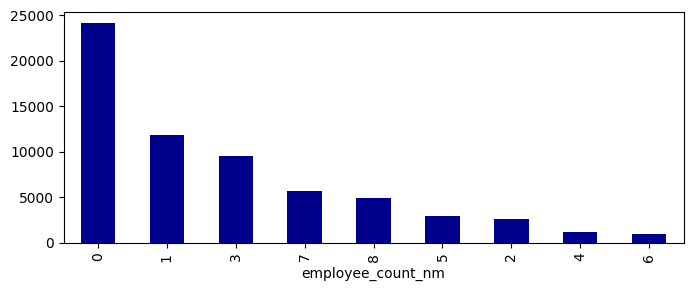

In [56]:
df_copy.employee_count_nm.value_counts().plot(kind='bar', figsize=(8,3), color='darkblue')
plt.xlabel('employee_count_nm')

Text(0, 0.5, 'customer_age')

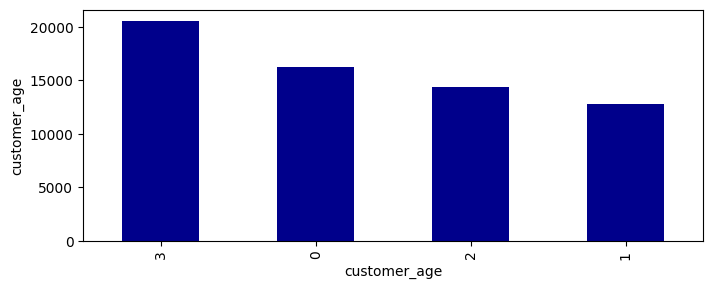

In [57]:
df.customer_age.value_counts().plot(kind='bar', figsize=(8,3), color='darkblue')
plt.ylabel('customer_age')

<Axes: xlabel='freq_weekday', ylabel='time'>

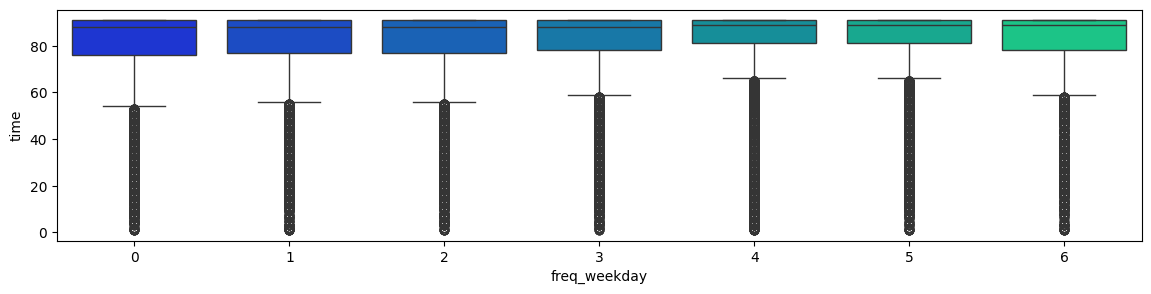

In [58]:
plt.figure(figsize=(14,3))
sns.boxplot(df, x ='freq_weekday', y='time', palette='winter')

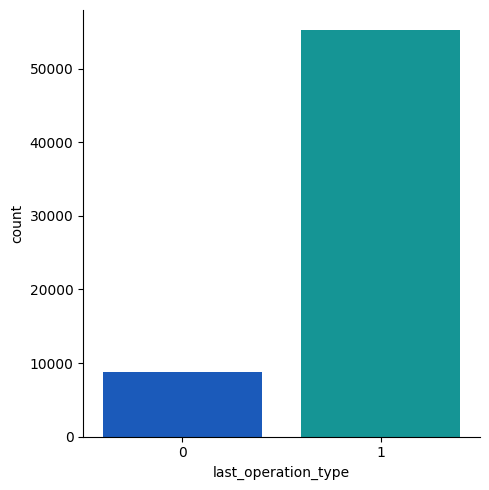

In [59]:
sns.catplot(x ='last_operation_type', kind = 'count', data = df, palette='winter')

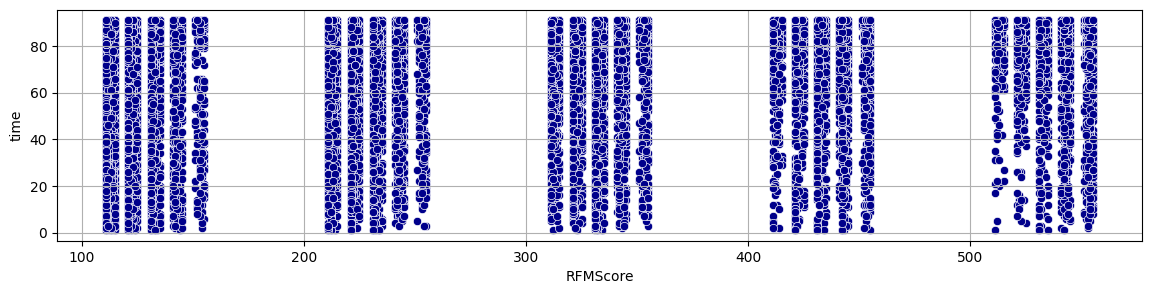

In [60]:
plt.figure(figsize = (14,3))
sns.scatterplot(data = df, y= 'time', x= 'RFMScore', color='darkblue')
plt.grid()

<Axes: xlabel='last_operation_summ'>

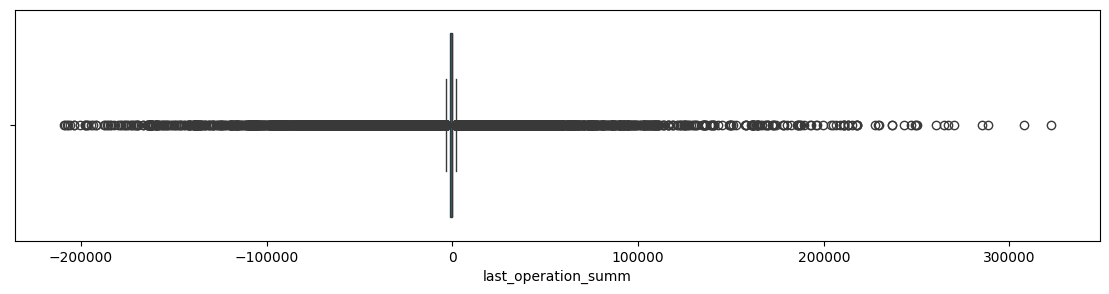

In [61]:
plt.figure(figsize=(14,3))
sns.boxplot(df_copy, x ='last_operation_summ', palette='winter')

<Axes: xlabel='total_amount_out'>

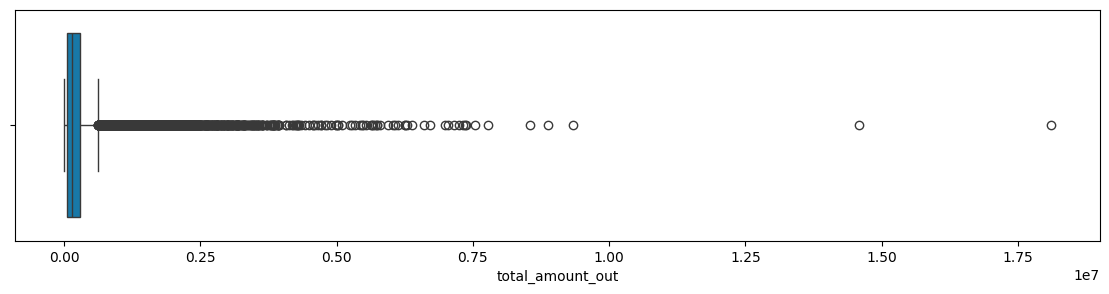

In [62]:
plt.figure(figsize=(14,3))
sns.boxplot(df, x ='total_amount_out', palette='winter')

<Axes: xlabel='total_amount_in'>

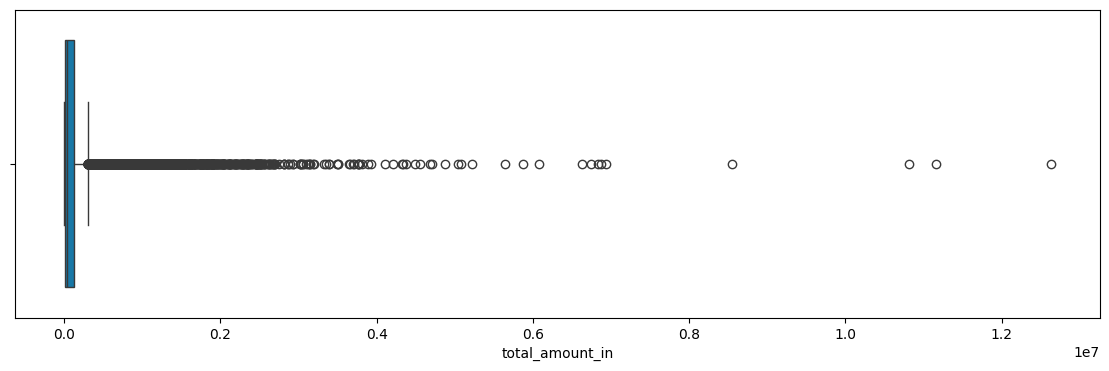

In [63]:
plt.figure(figsize=(14,4))
sns.boxplot(df, x ='total_amount_in', palette='winter')

In [64]:
# дает результат чуть хуже
df['total_amount_out'] = np.log10(df['total_amount_out'])
df['total_amount_in'] = np.log10(df['total_amount_in'])

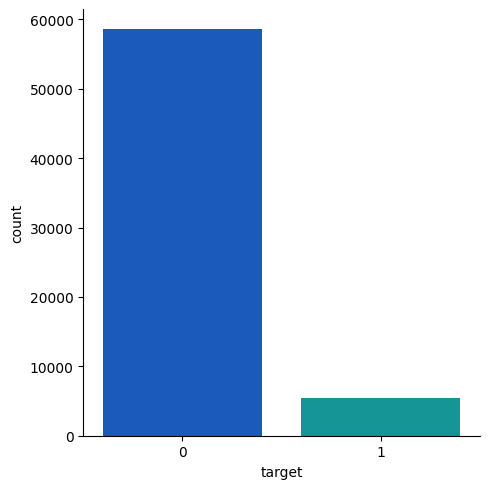

In [65]:
sns.catplot(x ='target', kind = 'count', data = df, palette='winter')
# увеличение класса не дает результат лучше

<Axes: >

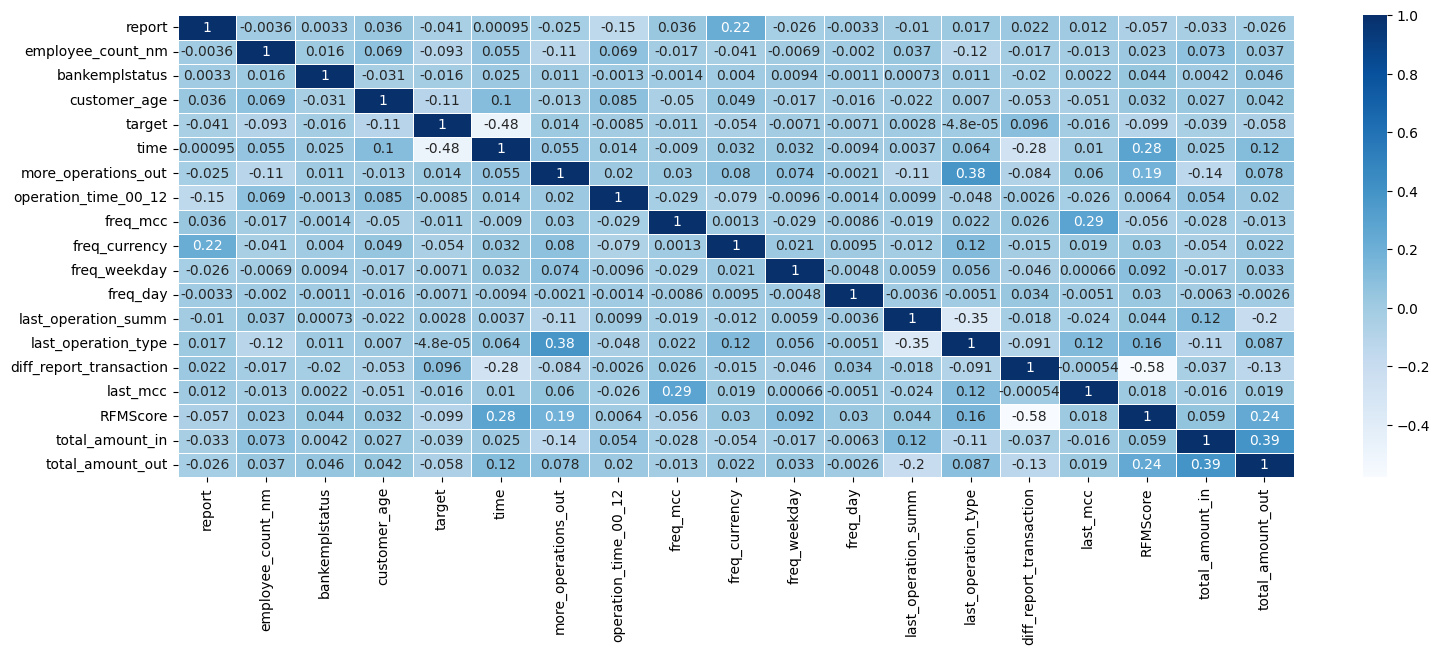

In [66]:
plt.figure(figsize=(18,6))
sns.heatmap(df_copy.corr(numeric_only=True), annot = True, linewidths=.5, cmap = 'Blues')

In [67]:
# df.to_csv('/content/drive/MyDrive/datasets/ottok/df.csv', index=False)

**RandomSurvivalForest**

In [68]:
Q1 = df_copy.quantile(0.05)
Q3 = df_copy.quantile(0.95)
IQR = Q3 - Q1
print(IQR)

# удаление аномалий приводит к сокращению данных
# df_copy = df_copy[~((df_copy<(Q1 - 1.5 * IQR))|(df_copy>(Q3 + 1.5 * IQR))).any(axis= 1)]

report                         11.000000
employee_count_nm               8.000000
bankemplstatus                  0.000000
customer_age                    3.000000
target                          1.000000
time                           59.000000
more_operations_out             1.000000
operation_time_00_12            1.000000
freq_mcc                       26.000000
freq_currency                   0.000000
freq_weekday                    6.000000
freq_day                       27.000000
last_operation_summ         30905.206201
last_operation_type             1.000000
diff_report_transaction        29.000000
last_mcc                       78.000000
RFMScore                      443.000000
total_amount_in            527411.968707
total_amount_out           722382.049794
dtype: float64


In [69]:
df_copy.shape

(64000, 19)

In [70]:
y = df_copy[['target', 'time']]
y['target'] = y['target'].astype('bool')
X = df_copy.drop(columns= ['target', 'time'])

In [71]:
for col in X.columns:
  X[col] = X[col].fillna(0)

In [72]:
# # нормализация признаков не дает результат
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
X = pd.DataFrame(StandardScaler().fit_transform(X),
                       columns = X.columns)

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state = 234)

In [74]:
y_train = y_train.to_records(index=False)
y_train = np.array(y_train, dtype = y_train.dtype.descr)
y_test = y_test.to_records(index=False)
y_test = np.array(y_test, dtype = y_test.dtype.descr)

In [75]:
# # максимум дает 0.74
rsf = RandomSurvivalForest(
    max_depth = 5,
    min_samples_leaf= 10,
    n_estimators=100,
    random_state=1234,
    low_memory=True)
rsf.fit(X_train, y_train)
rsf.score(X_test, y_test)

0.7393092477151937

In [76]:
from sklearn.inspection import permutation_importance
result = permutation_importance(rsf, X_test, y_test, n_repeats=15, random_state=1234)

In [77]:
pd.DataFrame(
    {
        k: result[k]
        for k in (
            "importances_mean",
            "importances_std",
        )
    },
    index=X_test.columns,
).sort_values(by="importances_mean", ascending=False)

,importances_mean,importances_std
employee_count_nm,0.050585,0.002971
diff_report_transaction,0.025548,0.002514
customer_age,0.022719,0.002506
RFMScore,0.014873,0.001865
total_amount_out,0.013544,0.002006
last_operation_summ,0.004613,0.001024
total_amount_in,0.004268,0.000922
report,0.002726,0.000679
freq_currency,0.002146,0.000957
freq_mcc,0.000562,0.000178


**CatBoost**

In [78]:
y = df['target']
X = df.drop(columns= ['target', 'time'])

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state = 234)

In [80]:
cbc = CatBoostClassifier(iterations=3000,
                          # loss_function='Logloss',
                          eval_metric='AUC',
                          l2_leaf_reg = 5,
                          depth = 5,#10,#5
                          metric_period=300,
                          thread_count=6,
                          learning_rate= 0.01,
                          early_stopping_rounds=200,
                          # bootstrap_type='Bayesian',
                       )

In [81]:
cbc.fit(X_train,y_train, eval_set=(X_test, y_test), cat_features=['employee_count_nm'])

0:	test: 0.6330721	best: 0.6330721 (0)	total: 102ms	remaining: 5m 4s
300:	test: 0.7350201	best: 0.7350201 (300)	total: 14.8s	remaining: 2m 12s
600:	test: 0.7438859	best: 0.7438859 (600)	total: 29.7s	remaining: 1m 58s
900:	test: 0.7483438	best: 0.7483438 (900)	total: 43.5s	remaining: 1m 41s
1200:	test: 0.7512195	best: 0.7512207 (1199)	total: 1m	remaining: 1m 30s
1500:	test: 0.7527375	best: 0.7527375 (1500)	total: 1m 14s	remaining: 1m 14s
1800:	test: 0.7539658	best: 0.7539658 (1800)	total: 1m 28s	remaining: 59s
2100:	test: 0.7546857	best: 0.7546857 (2100)	total: 1m 42s	remaining: 43.9s
2400:	test: 0.7553320	best: 0.7554005 (2352)	total: 1m 56s	remaining: 29.1s
2700:	test: 0.7557984	best: 0.7558087 (2692)	total: 2m 10s	remaining: 14.5s
2999:	test: 0.7559146	best: 0.7559473 (2948)	total: 2m 24s	remaining: 0us

bestTest = 0.7559472967
bestIteration = 2948

Shrink model to first 2949 iterations.


In [82]:
# train_pool = Pool(X_train, y_train)
# grid = {
#     'learning_rate': [0.01, 0.03],
#     'depth':[3, 6, 9],
#     'l2_leaf_reg': [2, 3, 4],
#     'boosting_type': ['Ordered', 'Plain']
# }

# grid_search_model = CatBoostClassifier(iterations=300, random_seed=42)
# grid_search_result = grid_search_model.grid_search(grid, train_pool, verbose=20)

# grid_search_result['params']

In [83]:
df_pred = df_pred.drop(columns= ['target', 'time', 'user_id'])

In [84]:
res = cbc.predict_proba(df_pred)[:,1]
submit['predict'] = res

In [85]:
cbc.get_feature_importance( prettified=True)

,Feature Id,Importances
0,employee_count_nm,15.487610
1,total_amount_out,13.369469
2,total_amount_in,10.572266
3,customer_age,10.567289
4,RFMScore,9.680105
5,diff_report_transaction,8.296525
6,last_operation_summ,7.652507
7,freq_day,5.025812
8,last_mcc,4.978047
9,report,4.844793


In [86]:
submit.to_csv('submission.csv', index=False)

**CatBoostRegressor**

In [87]:
cbr = CatBoostRegressor(iterations=3000,
                          eval_metric='AUC',
                          l2_leaf_reg = 5,
                          depth = 5,
                          metric_period=200,
                          learning_rate= 0.01,
                          # boosting_type = 'Ordered',
                          early_stopping_rounds=200,
                         )

In [88]:
cbr.fit(X_train,y_train, eval_set=(X_test, y_test), cat_features=['employee_count_nm'])

0:	test: 0.7039669	best: 0.7039669 (0)	total: 24ms	remaining: 1m 11s
200:	test: 0.7338157	best: 0.7338157 (200)	total: 3.52s	remaining: 49.1s
400:	test: 0.7400513	best: 0.7400636 (399)	total: 7.3s	remaining: 47.3s
600:	test: 0.7444644	best: 0.7444644 (600)	total: 12.9s	remaining: 51.6s
800:	test: 0.7477799	best: 0.7477799 (800)	total: 16.6s	remaining: 45.6s
1000:	test: 0.7501679	best: 0.7501697 (999)	total: 20.3s	remaining: 40.5s
1200:	test: 0.7515447	best: 0.7515447 (1200)	total: 26.6s	remaining: 39.9s
1400:	test: 0.7524285	best: 0.7524285 (1399)	total: 31s	remaining: 35.4s
1600:	test: 0.7532003	best: 0.7532003 (1600)	total: 34.5s	remaining: 30.1s
1800:	test: 0.7539506	best: 0.7539506 (1800)	total: 39.2s	remaining: 26.1s
2000:	test: 0.7542406	best: 0.7542497 (1995)	total: 43.3s	remaining: 21.6s
2200:	test: 0.7545311	best: 0.7545311 (2200)	total: 46.8s	remaining: 17s
2400:	test: 0.7546790	best: 0.7547392 (2335)	total: 50.5s	remaining: 12.6s
2600:	test: 0.7547028	best: 0.7547873 (2562)	

In [89]:
cbr.get_feature_importance( prettified=True)

,Feature Id,Importances
0,employee_count_nm,16.856269
1,customer_age,14.523703
2,total_amount_out,13.805332
3,total_amount_in,12.289767
4,diff_report_transaction,9.114239
5,RFMScore,6.997430
6,last_operation_summ,5.224056
7,freq_day,5.022539
8,report,4.236770
9,freq_currency,3.754881


In [90]:
res = cbr.predict(df_pred)
submit['predict'] = res